In [ ]:
import os

print("Images:", len(os.listdir("images")))
print("Masks :", len(os.listdir("masks")))

print("First 5 image files:", os.listdir("images")[:5])
print("First 5 mask files :", os.listdir("masks")[:5])


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = UNet().to(device)


In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt



In [ ]:
print(Dataset)


<class 'torch.utils.data.dataset.Dataset'>


In [1]:
!ls ~/.kaggle


ls: cannot access '/root/.kaggle': No such file or directory


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!ls ~/.kaggle


kaggle.json


In [5]:
!kaggle competitions list | head


ref                                                                                 deadline             category                reward  teamCount  userHasEntered  
----------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-3       2026-04-15 23:59:00  Featured         2,207,152 Usd        940           False  
https://www.kaggle.com/competitions/vesuvius-challenge-surface-detection            2026-02-13 23:59:00  Research           200,000 Usd        432           False  
https://www.kaggle.com/competitions/google-tunix-hackathon                          2026-01-12 23:59:00  Featured           100,000 Usd         96           False  
https://www.kaggle.com/competitions/csiro-biomass                                   2026-01-28 23:59:00  Research            75,000 Usd       2415           False  
https://ww

In [6]:
!kaggle competitions download -c tgs-salt-identification-challenge --force


 96% 427M/445M [00:07<00:00, 64.0MB/s]
100% 445M/445M [00:07<00:00, 64.3MB/s]


In [7]:
!unzip tgs-salt-identification-challenge.zip
!ls


Archive:  tgs-salt-identification-challenge.zip
  inflating: competition_data.zip    
  inflating: depths.csv              
  inflating: flamingo.zip            
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.csv               
  inflating: train.zip               
competition_data.zip  sample_data			     train.csv
depths.csv	      sample_submission.csv		     train.zip
flamingo.zip	      test.zip
kaggle.json	      tgs-salt-identification-challenge.zip


In [8]:
!unzip train.zip


Streaming output truncated to the last 5000 lines.
  inflating: images/d80ead8703.png   
  inflating: images/b012e9ebb0.png   
  inflating: images/d3034e7a60.png   
  inflating: images/ae2ef70d51.png   
  inflating: images/1af44a9db0.png   
  inflating: images/41cfd4b320.png   
  inflating: images/853e89d0d3.png   
  inflating: images/2a484baa26.png   
  inflating: images/92e617896e.png   
  inflating: images/b70f0ab0c2.png   
  inflating: images/e8757626a1.png   
  inflating: images/6a3d92ce59.png   
  inflating: images/127ef4105f.png   
  inflating: images/d21012f5c1.png   
  inflating: images/1cb9549d2c.png   
  inflating: images/e030bdae65.png   
  inflating: images/0cf7155eb6.png   
  inflating: images/badb3ea766.png   
  inflating: images/9bd58061d6.png   
  inflating: images/2b1e71c2a3.png   
  inflating: images/28d42de29f.png   
  inflating: images/10833853b3.png   
  inflating: images/ef13247eed.png   
  inflating: images/bce104494c.png   
  inflating: images/c8ce151a18.png   

In [9]:
!ls


competition_data.zip  sample_data
depths.csv	      sample_submission.csv
flamingo.zip	      test.zip
images		      tgs-salt-identification-challenge.zip
kaggle.json	      train.csv
masks		      train.zip


In [11]:
!ls images | head
!ls masks | head


000e218f21.png
003c477d7c.png
00441f1cf2.png
0050766ae2.png
005b452274.png
0061281eea.png
008a50a2ec.png
00950d1627.png
00a3af90ab.png
00cda0328c.png
000e218f21.png
003c477d7c.png
00441f1cf2.png
0050766ae2.png
005b452274.png
0061281eea.png
008a50a2ec.png
00950d1627.png
00a3af90ab.png
00cda0328c.png


In [12]:
import os
print("Images:", len(os.listdir("images")))
print("Masks :", len(os.listdir("masks")))


Images: 4000
Masks : 4000


In [13]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [15]:
class TGSDataset(Dataset):
    def __init__(self, img_dir, mask_dir, files):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]

        img = cv2.imread(os.path.join(self.img_dir, fname), 0)
        img = cv2.resize(img, (128,128))
        img = img / 255.0
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)

        mask = cv2.imread(os.path.join(self.mask_dir, fname), 0)
        mask = cv2.resize(mask, (128,128))
        mask = (mask > 0).astype("float32")
        mask = torch.tensor(mask).unsqueeze(0)

        return img, mask


In [16]:
files = sorted(os.listdir("images"))

train_files, val_files = train_test_split(
    files, test_size=0.15, random_state=42
)

print(len(train_files), len(val_files))


3400 600


In [17]:
train_dataset = TGSDataset("images", "masks", train_files)
val_dataset   = TGSDataset("images", "masks", val_files)

train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True,
    num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=16, shuffle=False,
    num_workers=2, pin_memory=True
)

imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)


torch.Size([16, 1, 128, 128]) torch.Size([16, 1, 128, 128])


In [19]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc1 = DoubleConv(1, 32)
        self.enc2 = DoubleConv(32, 64)
        self.enc3 = DoubleConv(64, 128)

        self.pool = nn.MaxPool2d(2)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv(128, 64)

        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv(64, 32)

        self.out = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        c1 = self.enc1(x)
        p1 = self.pool(c1)

        c2 = self.enc2(p1)
        p2 = self.pool(c2)

        c3 = self.enc3(p2)

        u2 = self.up2(c3)
        u2 = torch.cat([u2, c2], dim=1)
        c4 = self.dec2(u2)

        u1 = self.up1(c4)
        u1 = torch.cat([u1, c1], dim=1)
        c5 = self.dec1(u1)

        return self.out(c5)


In [21]:
bce = nn.BCEWithLogitsLoss()

def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred).view(-1)
    target = target.view(-1)
    inter = (pred * target).sum()
    return 1 - (2*inter + smooth) / (pred.sum() + target.sum() + smooth)

optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [22]:
epochs = 15   # GPU হলে এটা safe

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)

        loss = 0.5 * bce(outputs, masks) + 0.5 * dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # validation every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs = imgs.to(device)
                masks = masks.to(device)
                outputs = model(imgs)
                val_loss += (0.5 * bce(outputs, masks) +
                             0.5 * dice_loss(outputs, masks)).item()
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}: Train {train_loss:.4f} | Val {val_loss:.4f}")
    else:
        print(f"Epoch {epoch+1}: Train {train_loss:.4f}")


Epoch 1: Train 0.6421
Epoch 2: Train 0.5172
Epoch 3: Train 0.4173
Epoch 4: Train 0.3794
Epoch 5: Train 0.3539 | Val 0.3243
Epoch 6: Train 0.3501
Epoch 7: Train 0.3325
Epoch 8: Train 0.3225
Epoch 9: Train 0.3039
Epoch 10: Train 0.2870 | Val 0.2655
Epoch 11: Train 0.2806
Epoch 12: Train 0.2763
Epoch 13: Train 0.2848
Epoch 14: Train 0.2576
Epoch 15: Train 0.2438 | Val 0.2499


In [23]:
model.eval()

# take one validation image
img, gt_mask = val_dataset[0]

img_input = img.unsqueeze(0).to(device)

with torch.no_grad():
    pred = model(img_input)
    pred = torch.sigmoid(pred).cpu().squeeze().numpy()

gt_mask = gt_mask.squeeze().numpy()
img_np = img.squeeze().numpy()


In [24]:
threshold = 0.5
pred_bin = (pred > threshold).astype("float32")


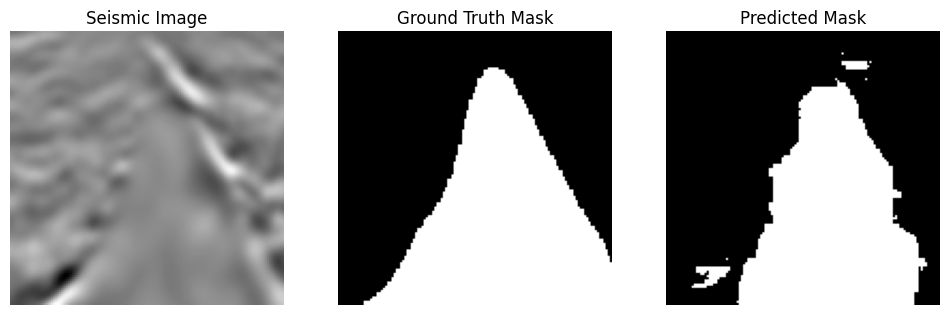

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_np, cmap="gray")
plt.title("Seismic Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt_mask, cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred_bin, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


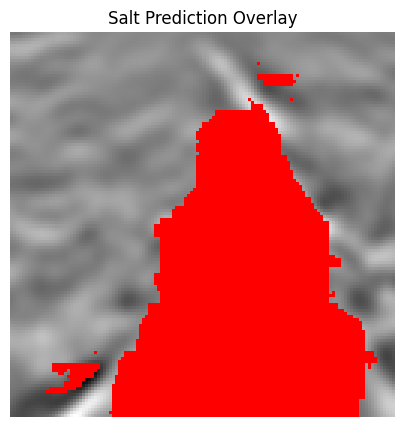

In [26]:
overlay = np.stack([img_np, img_np, img_np], axis=-1)

overlay[pred_bin == 1, 0] = 1.0   # Red
overlay[pred_bin == 1, 1] = 0.0
overlay[pred_bin == 1, 2] = 0.0

plt.figure(figsize=(5,5))
plt.imshow(overlay)
plt.title("Salt Prediction Overlay")
plt.axis("off")
plt.show()


In [27]:
pred_bin = (pred > 0.5).astype(np.uint8)


In [30]:
def dice_score(pred, target):
    smooth = 1e-6
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2*intersection + smooth) / (pred.sum() + target.sum() + smooth)


In [32]:
dir()

['DataLoader',
 'Dataset',
 'DoubleConv',
 'In',
 'Out',
 'TGSDataset',
 'UNet',
 '_',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_exit_code',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i31',
 '_i32',
 '_i4',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'bce',
 'cv2',
 'device',
 'dice_loss',
 'dice_score',
 'epoch',
 'epochs',
 'exit',
 'files',
 'get_ipython',
 'gt_mask',
 'img',
 'img_input',
 'img_np',
 'imgs',
 'loss',
 'masks',
 'model',
 'nn',
 'np',
 'optim',
 'optimizer',
 'os',
 'outputs',
 'overlay',
 'plt',
 'pred',
 'pred_bin',
 'quit',
 'threshold',
 'torch',
 'train_dataset',
 'train_files',
 'train_loader',
 'train_loss',
 'train_test_split',
 'val_dataset',
 'val_files',
 'val_load

In [34]:
def dice_score_np(pred, target, smooth=1e-6):
    pred = pred.reshape(-1)
    target = target.reshape(-1)
    intersection = (pred * target).sum()
    return (2 * intersection + smooth) / (pred.sum() + target.sum() + smooth)


In [35]:
dice = dice_score_np(pred_bin, gt_mask)
print("Dice Score:", dice)


Dice Score: 0.8948574136270749


In [36]:
plt.imsave("seismic.png", img_np, cmap="gray")
plt.imsave("ground_truth.png", gt_mask, cmap="gray")
plt.imsave("prediction.png", pred_bin, cmap="gray")
plt.imsave("overlay.png", overlay)


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

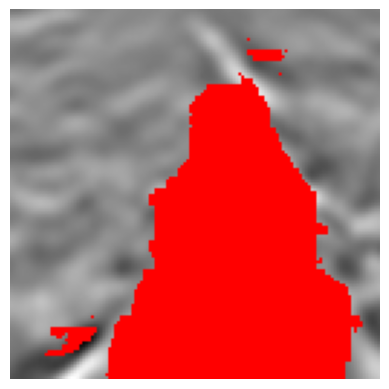

In [37]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("overlay.png")
plt.imshow(img)
plt.axis("off")


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

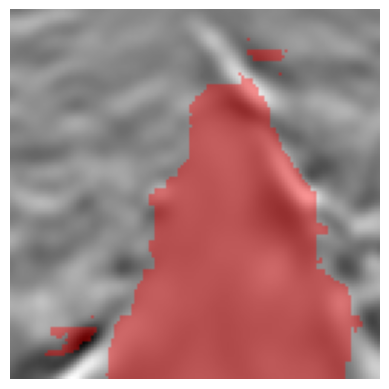

In [38]:
overlay = img_np.copy()
overlay = np.stack([overlay, overlay, overlay], axis=-1)

alpha = 0.4
overlay[pred_bin == 1] = (
    (1 - alpha) * overlay[pred_bin == 1] + alpha * np.array([1, 0, 0])
)

plt.imshow(overlay)
plt.axis("off")


In [39]:
plt.imsave("final_salt_overlay.png", overlay)
